In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from scipy.stats import randint

In [50]:
# Load and inspect data
data = pd.read_csv("/Users/yeshwanthsatyadev/Downloads/loan_data_set.csv")
print(data.head())
print(data.info())
print(data.describe())
print(data.isnull().sum())

    Loan_ID Gender Married Dependents     Education Self_Employed  \
0  LP001002   Male      No          0      Graduate            No   
1  LP001003   Male     Yes          1      Graduate            No   
2  LP001005   Male     Yes          0      Graduate           Yes   
3  LP001006   Male     Yes          0  Not Graduate            No   
4  LP001008   Male      No          0      Graduate            No   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             5849                0.0         NaN             360.0   
1             4583             1508.0       128.0             360.0   
2             3000                0.0        66.0             360.0   
3             2583             2358.0       120.0             360.0   
4             6000                0.0       141.0             360.0   

   Credit_History Property_Area Loan_Status  
0             1.0         Urban           Y  
1             1.0         Rural           N  
2             1.0   

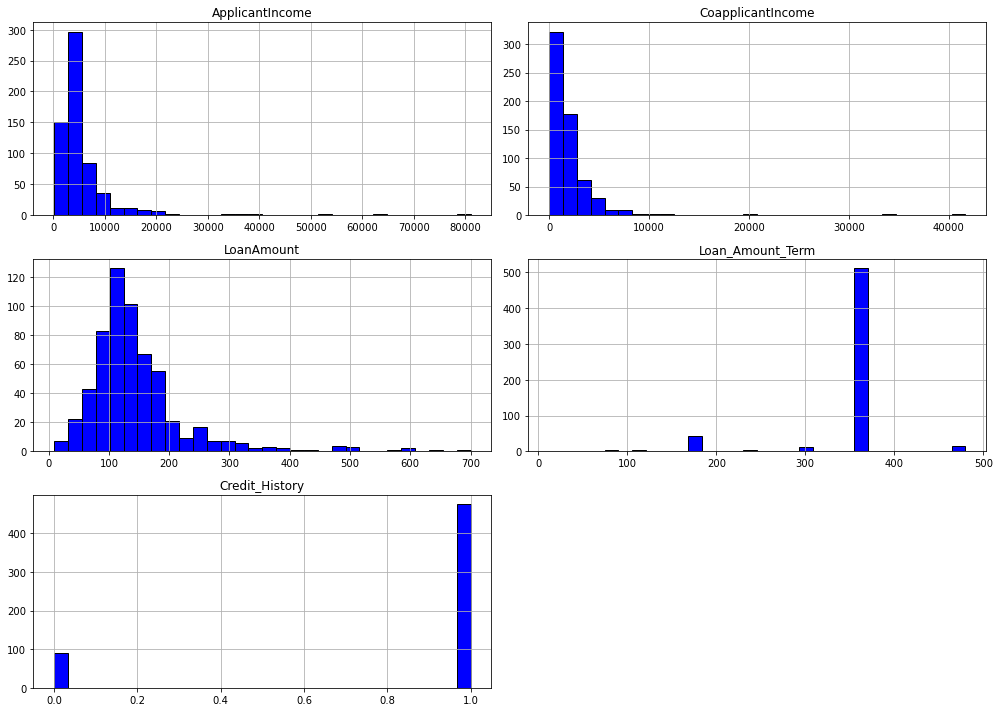

In [51]:
# Histograms for numerical features
data.hist(bins=30, figsize=(14, 10), color='blue', edgecolor='black')
plt.tight_layout()
plt.show()

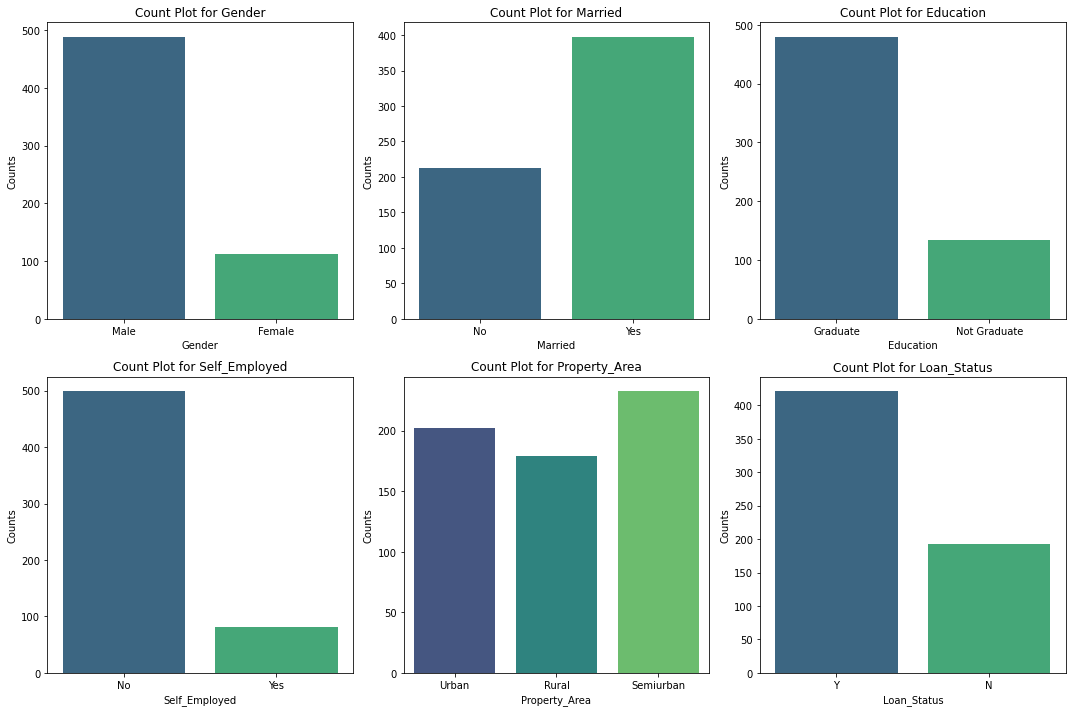

In [52]:
# Count plots for categorical features
categorical_features = ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()
for ax, cat_feature in zip(axes, categorical_features):
    sns.countplot(x=cat_feature, data=data, ax=ax, palette='viridis')
    ax.set_title(f'Count Plot for {cat_feature}')
    ax.set_ylabel('Counts')
    plt.tight_layout()

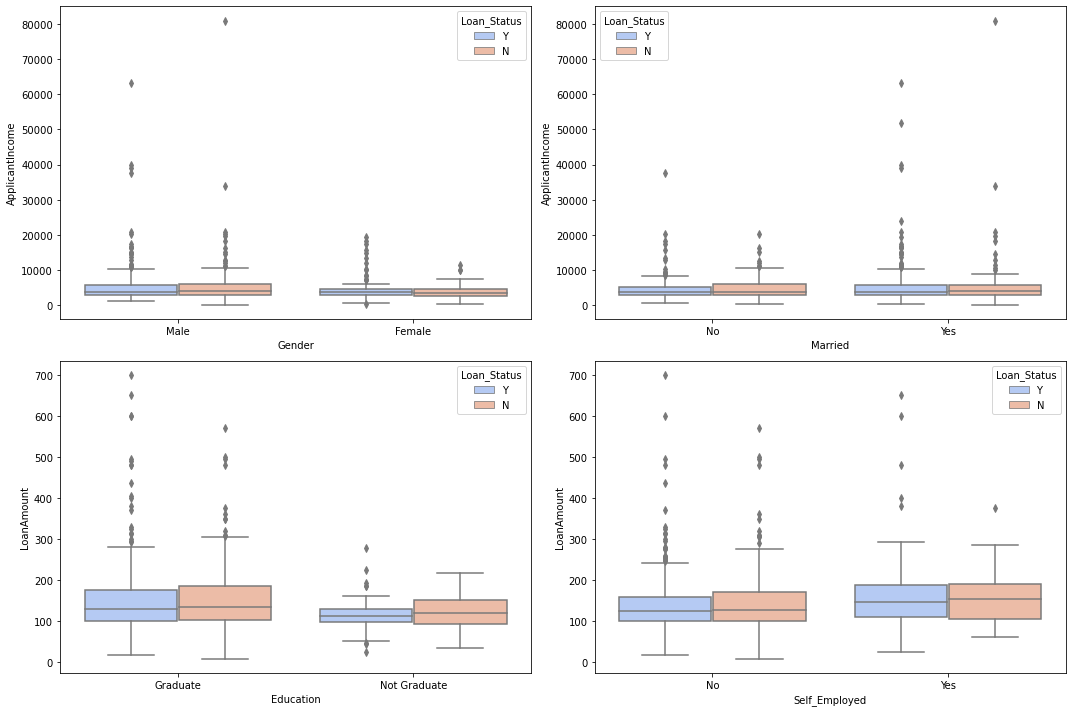

In [53]:
# Boxplots for examining income and loan amount distributions by categorical features
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()
sns.boxplot(x='Gender', y='ApplicantIncome', data=data, hue='Loan_Status', ax=axes[0], palette='coolwarm')
sns.boxplot(x='Married', y='ApplicantIncome', data=data, hue='Loan_Status', ax=axes[1], palette='coolwarm')
sns.boxplot(x='Education', y='LoanAmount', data=data, hue='Loan_Status', ax=axes[2], palette='coolwarm')
sns.boxplot(x='Self_Employed', y='LoanAmount', data=data, hue='Loan_Status', ax=axes[3], palette='coolwarm')
plt.tight_layout()
plt.show()

<ipython-input-54-7b86dc50e227>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr().round(2), annot=True, linewidths=0.5, cmap="Blues")


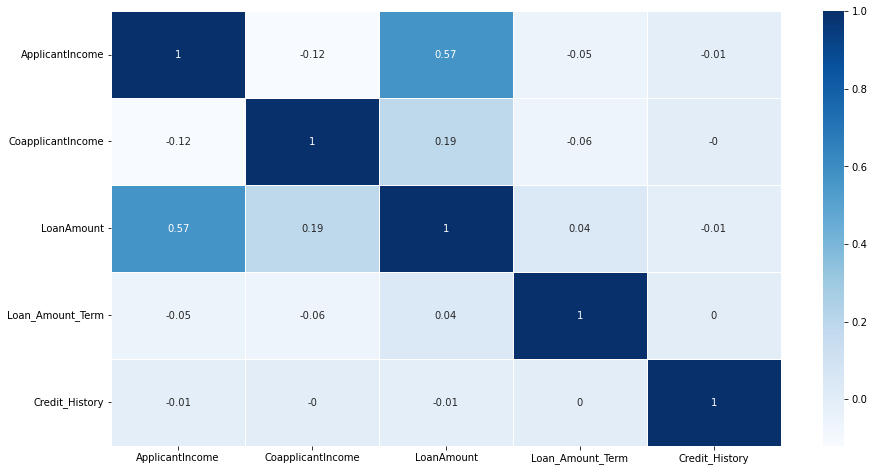

In [54]:
# Visualize correlations
fig, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(data.corr().round(2), annot=True, linewidths=0.5, cmap="Blues")
plt.show()


In [55]:
# Data Preprocessing
# Fill missing values
fill_modes = ['Gender', 'Married', 'Dependents', 'Self_Employed', 'Credit_History']
for column in fill_modes:
    mode_value = data[column].mode()[0]
    data[column].fillna(mode_value, inplace=True)

In [56]:
data.replace({'Dependents': {'3+': 4}}, inplace=True)
data['LoanAmount'].fillna(data['LoanAmount'].mean(), inplace=True)
data['Loan_Amount_Term'].fillna(data['Loan_Amount_Term'].mean(), inplace=True)
data['CoapplicantIncome'].replace(0, data['CoapplicantIncome'].mean(), inplace=True)

In [57]:
# Drop ID column
data.drop(columns=['Loan_ID'], inplace=True)

In [58]:
# Encode categorical variables
data.replace({
    'Gender': {'Male': 1, 'Female': 0},
    'Married': {'Yes': 1, 'No': 0},
    'Education': {'Graduate': 1, 'Not Graduate': 0},
    'Self_Employed': {'Yes': 1, 'No': 0},
    'Property_Area': {'Semiurban': 0, 'Urban': 1, 'Rural': 2},
    'Loan_Status': {'Y': 1, 'N': 0}
}, inplace=True)

In [59]:
data

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,1,0,0,1,0,5849,1621.245798,146.412162,360.0,1.0,1,1
1,1,1,1,1,0,4583,1508.000000,128.000000,360.0,1.0,2,0
2,1,1,0,1,1,3000,1621.245798,66.000000,360.0,1.0,1,1
3,1,1,0,0,0,2583,2358.000000,120.000000,360.0,1.0,1,1
4,1,0,0,1,0,6000,1621.245798,141.000000,360.0,1.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
609,0,0,0,1,0,2900,1621.245798,71.000000,360.0,1.0,2,1
610,1,1,4,1,0,4106,1621.245798,40.000000,180.0,1.0,2,1
611,1,1,1,1,0,8072,240.000000,253.000000,360.0,1.0,1,1
612,1,1,2,1,0,7583,1621.245798,187.000000,360.0,1.0,1,1


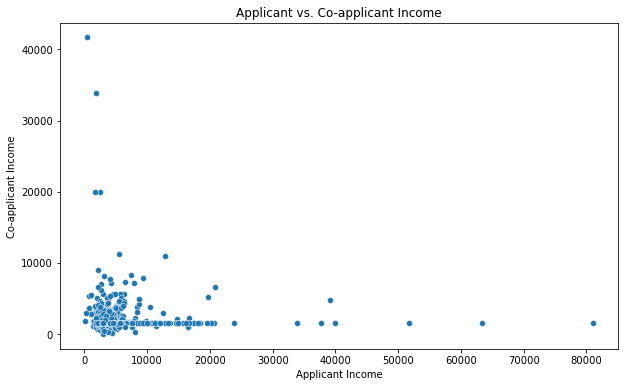

In [60]:
# Scatter plot for identifying outliers between applicant and co-applicant incomes
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data['ApplicantIncome'], y=data['CoapplicantIncome'])
plt.title('Applicant vs. Co-applicant Income')
plt.xlabel('Applicant Income')
plt.ylabel('Co-applicant Income')
plt.show()

In [61]:
# Outlier removal
data = data[(data['ApplicantIncome'] <= 30000) & (data['CoapplicantIncome'] < 8000)]
data.reset_index(drop=True, inplace=True)

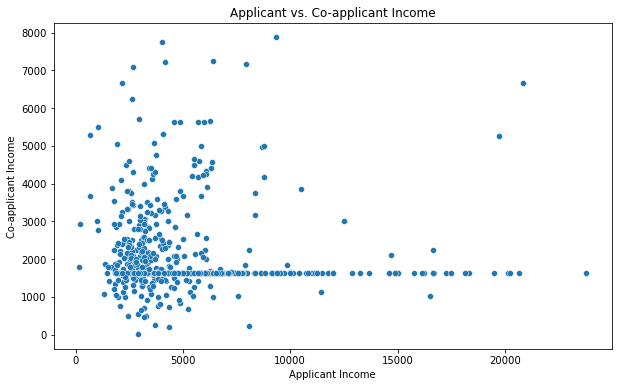

In [62]:
# Scatter plot for identifying outliers between applicant and co-applicant incomes
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data['ApplicantIncome'], y=data['CoapplicantIncome'])
plt.title('Applicant vs. Co-applicant Income')
plt.xlabel('Applicant Income')
plt.ylabel('Co-applicant Income')
plt.show()

In [63]:
# Model training and evaluation
features = data.drop('Loan_Status', axis=1)
target = data['Loan_Status']
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=3, stratify=target)

In [64]:
# Random Forest Classifier
rf_param_grid = {
    'n_estimators': randint(100, 1000),
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None] + list(range(5, 30, 5)),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'bootstrap': [True, False]
}

In [65]:
rf_model = RandomForestClassifier()
rf_random_search = RandomizedSearchCV(rf_model, param_distributions=rf_param_grid, n_iter=10, cv=5, scoring='accuracy', random_state=42)
rf_random_search.fit(X_train, y_train)
print("Best RF parameters:", rf_random_search.best_params_)
print("Best RF score:", rf_random_search.best_score_)

Best RF parameters: {'bootstrap': True, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 15, 'min_samples_split': 12, 'n_estimators': 171}
Best RF score: 0.8138815789473683


In [66]:
# Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

/Users/yeshwanthsatyadev/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

In [67]:
# Support Vector Machine
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

SVC(kernel='linear')

In [68]:
# Evaluate models
models = {'Random Forest': rf_random_search.best_estimator_, 'Logistic Regression': lr_model, 'SVM': svm_model}
for name, model in models.items():
    predictions = model.predict(X_test)
    accuracy = metrics.accuracy_score(predictions, y_test)
    f1 = metrics.f1_score(predictions, y_test)
    recall = metrics.recall_score(predictions, y_test)
    precision = metrics.precision_score(predictions, y_test)
    print(f"{name} - Accuracy: {accuracy}, F1 Score: {f1}, Recall: {recall}, Precision: {precision}")


Random Forest - Accuracy: 0.825, F1 Score: 0.8877005347593583, Recall: 0.7980769230769231, Precision: 1.0
Logistic Regression - Accuracy: 0.825, F1 Score: 0.8877005347593583, Recall: 0.7980769230769231, Precision: 1.0
SVM - Accuracy: 0.7916666666666666, F1 Score: 0.8677248677248677, Recall: 0.7735849056603774, Precision: 0.9879518072289156
